In [1]:
import torch
import numpy as np
import pandas as pd
import anndata as ad
import multiDGD
import random
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# print directory
import os
print(os.getcwd())
os.chdir("../..")
print(os.getcwd())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set a random seed
seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# import utils functions
from src.models.sparse_autoencoder import *
from src.visualization.plotting import *

/home/dbm829/projects/interpreting_omics_models/02_experiments/notebooks
/home/dbm829/projects/interpreting_omics_models


### load models and compute activations

In [2]:
data = ad.read_h5ad('./01_data/human_bonemarrow.h5ad')

model = multiDGD.DGD.load(data=data, save_dir='./03_results/models/', model_name='human_bonemarrow_l20_h2-3_test50e')

reps = model.representation.z.detach()

Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


/home/dbm829/.conda/envs/sc_mechinterp/lib/python3.9/site-packages/multiDGD/_dgd.py:393: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self._save_dir

In [3]:
# load the model
sae_model_save_name = '03_results/models/sae_model_10000_l1-1e-3_lr-1e-4_500epochs'

input_size = reps.shape[1]
hidden_size = 10**4
sae_model = SparseAutoencoder(input_size, hidden_size)
sae_model.load_state_dict(torch.load(sae_model_save_name+'.pt'))
sae_model.to(device)

batch_size = 128
train_data = reps.clone()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

/tmp/ipykernel_1625381/2016938740.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_model.load_state_dict(torch.load(sae_model_save_name+'.pt'))


In [9]:
threshold = 1e-10

unique_active_unit_indices = get_unique_active_unit_indices(sae_model, train_loader, threshold=threshold)
print(f'Unique Active Neuron Indices: {unique_active_unit_indices}')
print(f'Number of unique active hidden units: {len(unique_active_unit_indices)}')

avg_active_hidden_units = count_active_hidden_units(sae_model, train_loader, threshold=threshold, avg=True)
print(f'Average number of active hidden units per sample: {avg_active_hidden_units:.2f}')

pca = PCA(n_components=2)
pca.fit(reps.cpu().numpy())
reps_transformed = pca.transform(reps.cpu().numpy())
reps_reconstructed, activations = sae_model(torch.tensor(reps, dtype=torch.float32).to(device))

data = data[data.obs["train_val_test"] == "train"]

Unique Active Neuron Indices: [2, 4, 5, 10, 11, 12, 13, 14, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 34, 36, 37, 38, 43, 45, 47, 48, 49, 50, 51, 54, 56, 59, 61, 64, 66, 67, 70, 71, 73, 75, 77, 80, 81, 82, 84, 85, 86, 87, 88, 89, 93, 94, 95, 97, 98, 99, 100, 101, 104, 106, 107, 109, 112, 114, 115, 117, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 137, 139, 140, 143, 144, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 165, 168, 172, 173, 174, 175, 178, 181, 182, 184, 188, 189, 190, 191, 192, 196, 198, 199, 201, 202, 204, 205, 206, 208, 209, 211, 212, 213, 214, 218, 220, 221, 222, 223, 224, 225, 227, 229, 237, 239, 240, 243, 246, 247, 249, 250, 251, 252, 254, 256, 261, 262, 263, 264, 265, 266, 268, 271, 272, 273, 274, 275, 278, 279, 281, 283, 284, 286, 289, 290, 291, 293, 298, 299, 302, 304, 306, 307, 309, 310, 312, 313, 314, 315, 316, 317, 320, 322, 324, 325, 326, 328, 330, 331, 335, 336, 337, 343, 346, 347, 348, 349, 350, 351, 352, 353, 355, 356, 3

/tmp/ipykernel_1625381/3666530927.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reps_reconstructed, activations = sae_model(torch.tensor(reps, dtype=torch.float32).to(device))


In [83]:
# Assuming 'model' is your trained SparseAutoencoder and 'data_loader' is your dataset loader
def count_active_hidden_units(model, reps, threshold=1e-5, avg=True):

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():  # Disable gradient calculations for efficiency
            # Forward pass through the encoder to get the hidden layer activations
        _, encoded = model(torch.tensor(reps, dtype=torch.float32).to(device))
            
        # Count how many activations are above the threshold (active neurons)
        active_units_per_sample = (encoded > threshold).sum(dim=1)
    
    if avg:
        avg_active_units = sum(active_units_per_sample) / encoded.shape[0]
        return avg_active_units
    else:
        return active_units_per_sample

In [85]:
# count the active hidden units for each sample
# and plot the average number of active hidden units over celltypes

active_hidden_units = count_active_hidden_units(sae_model, reps, threshold=threshold, avg=False)

/tmp/ipykernel_583773/3260842430.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, encoded = model(torch.tensor(reps, dtype=torch.float32).to(device))


In [ ]:
df_temp = pd.DataFrame(data=active_hidden_units.detach().cpu().numpy(), columns=['active_hidden_units'])
df_temp['celltype'] = data.obs['cell_type'].values

# plot a bar plot of the average number of active hidden units per celltype
plt.figure(figsize=(12, 6))
sns.barplot(x='celltype', y='active_hidden_units', data=df_temp)
plt.xticks(rotation=90)
plt.ylabel('Number of active hidden units')
plt.title('Average number of active hidden units per celltype')
plt.show()

### general plots

In [6]:
data = data[data.obs["train_val_test"] == "train"]

reps_reconstructed, activations = sae_model(torch.tensor(reps, dtype=torch.float32).to(device))

/tmp/ipykernel_1625381/3482166546.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reps_reconstructed, activations = sae_model(torch.tensor(reps, dtype=torch.float32).to(device))


In [ ]:
avg_activation_per_neuron = activations.detach().cpu().mean(dim=0).numpy()
df_avg_activs = pd.DataFrame(data=avg_activation_per_neuron, columns=['mean activation'])
df_avg_activs['active'] = ['active' if i in unique_active_unit_indices else 'dead' for i in range(avg_activation_per_neuron.shape[0])]

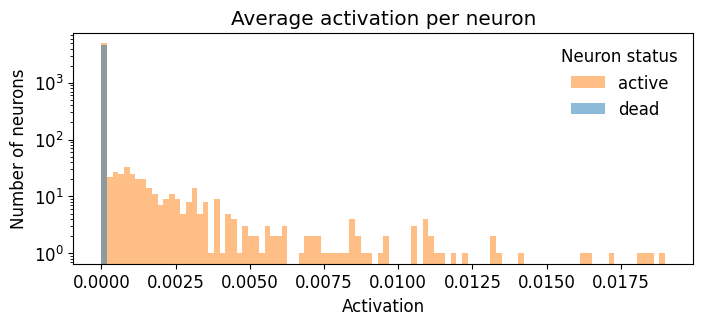

In [38]:
# plot the avg activation per neuron as histogram
# set font size to 12
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(8, 3))
sns.histplot(data=df_avg_activs, x='mean activation', hue='active', bins=100, common_norm=False, alpha=0.5, linewidth=0)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Activation')
plt.ylabel('Number of neurons')
plt.title('Average activation per neuron')
plt.legend(['active', 'dead'], title='Neuron status', frameon=False)
plt.show()

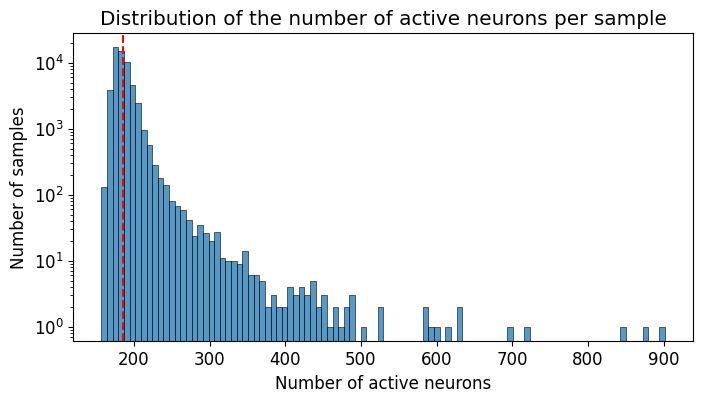

In [41]:
# get a distribution of the number of firing neurons per sample
num_active_neurons = (activations > threshold).sum(dim=1).detach().cpu().numpy()

# plot the distribution of the number of firing neurons per sample
plt.figure(figsize=(8, 4))
sns.histplot(num_active_neurons, bins=100)
# put a line at the average
plt.axvline(x=avg_active_hidden_units, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Number of active neurons')
plt.ylabel('Number of samples')
plt.title('Distribution of the number of active neurons per sample')
plt.show()

# Looking into features increasing with hematopoiesis

In [20]:
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial
from statsmodels.stats.multitest import multipletests

# get the model's dispersions for the test
with torch.no_grad():
    dispersion_factors = (torch.exp(model.decoder.out_modules[0].distribution.log_r).detach().cpu().numpy() + 1).flatten()

## finding features per cell type perturbation

In [12]:
stricter_selection = [1422, 2019, 2091, 2306, 4525, 4621, 4881, 5557, 5687, 5793, 6352, 7491, 7494, 7965, 8026, 8048]

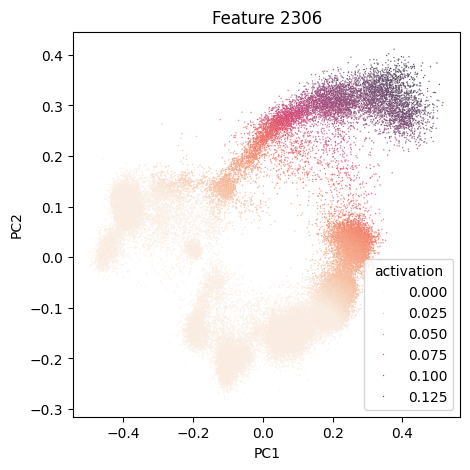

In [30]:
# plot the latents colored by the value of feature 2306
feat = 2306

df_temp = pd.DataFrame(reps_transformed, columns=["PC1", "PC2"])
df_temp['activation'] = activations[:, feat].detach().cpu().numpy()
# sort by activations
df_temp = df_temp.sort_values(by='activation', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='PC1', y='PC2', hue='activation', ax=ax, palette='rocket_r', s=1, alpha=0.7)
plt.title(f'Feature {feat}')
plt.show()

### HSC -> proerythroblast

In [ ]:
ct1 = 'HSC'
ct2 = 'Normoblast'

ct1_indices = np.where(data.obs['cell_type'] == ct1)[0]
latents_non_ct1 = reps[np.where(data.obs['cell_type'] != ct1)[0], :].cpu().numpy()
latents_ct1 = reps[ct1_indices, :].cpu().numpy()
activs_ct1 = activations[ct1_indices, :]
active_values_ct2 = torch.Tensor(np.mean(activations[np.where(data.obs['cell_type'] == ct2)[0],:].detach().cpu().numpy(), axis=0)).to(device)

# for each feature, get the HSC samples and plot the predicted latents before and after perturbation

# make a figure with 4 columns and as many rows as needed for the features

if len(stricter_selection) % 4 == 0:
    n_rows = len(stricter_selection) // 4
else:
    n_rows = len(stricter_selection) // 4 + 1

fig, axs = plt.subplots(n_rows, 4, figsize=(20, 4*n_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

i = 0
for feat in stricter_selection:
    activs_perturbed = activs_ct1.clone()
    activs_perturbed[:, feat] = active_values_ct2[feat]
    latents_perturbed = sae_model.decoder(activs_perturbed.to(device)).detach().cpu().numpy()

    df_temp = pd.DataFrame(reps_transformed, columns=['PC 1', 'PC 2'])
    df_temp['type'] = 'other'
    df_temp2 = pd.DataFrame(pca.transform(latents_ct1), columns=['PC 1', 'PC 2'])
    df_temp2['type'] = 'HSC'
    df_temp = pd.concat([df_temp, df_temp2])
    df_temp2 = pd.DataFrame(pca.transform(latents_perturbed), columns=['PC 1', 'PC 2'])
    df_temp2['type'] = 'HSC perturbed'
    df_temp = pd.concat([df_temp, df_temp2])

    col, row = i % 4, i // 4
    sns.scatterplot(df_temp, x='PC 1', y='PC 2', hue='type', ax=axs[row, col], s=1, alpha=0.7, palette=['grey', 'blue', 'red'])
    axs[row, col].get_legend().remove()
    axs[row, col].set_title(f'Feature {feat}')
    i = i + 1

plt.show()

In [ ]:
feat = 2306

###
# make perturbations
###

# get hsc latents
hsc_indices = np.where(data.obs['cell_type'] == 'HSC')[0]
latents_hsc = reps[hsc_indices, :]
cov_latents_hsc = model.correction_rep.z.detach()[hsc_indices, :]

# get activations
activs_hsc = activations[hsc_indices, :]
active_values_normoblast = torch.Tensor(np.mean(activations[np.where(data.obs['cell_type'] == 'Normoblast')[0],:].detach().cpu().numpy(), axis=0)).to(device)

# predict perturbations
activs_perturbed = activs_hsc.clone()
activs_perturbed[:, feat] = active_values_normoblast[feat]
latents_perturbed = sae_model.decoder(activs_perturbed.to(device))

# feed these latents into the dgd model and then do differential gene expression analysis on the predicted outputs
y_hsc = model.decoder(torch.cat((latents_hsc, cov_latents_hsc), dim=1))[0].detach().cpu().numpy()
y_perturb = model.decoder(torch.cat((latents_perturbed, cov_latents_hsc), dim=1))[0].detach().cpu().numpy()

# the predictions need to be scaled by the sum of the modality
library = data.obs['GEX_n_counts'].values[hsc_indices]
y_hsc = y_hsc * library.reshape(-1, 1)
y_perturb = y_perturb * library.reshape(-1, 1)

# Stack y_hsc and y_perturb side by side, resulting in (n_cells * 2, n_genes)
n_cells = y_hsc.shape[0]
n_genes = y_hsc.shape[1]

# Prepare condition and pairing information
# Condition: 0 for HSC, 1 for perturbation
conditions = np.array([0] * n_cells + [1] * n_cells)

# Pairing: Each pair corresponds to the same cell in HSC and perturbation
pairing = np.tile(np.arange(n_cells), 2)

# Initialize lists to store p-values and fold changes for each gene
p_values = []
fold_changes = []

# Loop over each gene (column)
for gene_idx in range(n_genes):
    # Combine the gene expression data for the current gene across both conditions
    gene_expression = np.concatenate([y_hsc[:, gene_idx], y_perturb[:, gene_idx]])

    # Design matrix: Intercept (ones), pairing, and condition
    X = np.column_stack([np.ones_like(conditions), pairing, conditions])

    # Fit a negative binomial model for the current gene
    glm_model = sm.GLM(gene_expression, X, family=NegativeBinomial(alpha=dispersion_factors[gene_idx]))
    result = glm_model.fit()

    # Extract p-value for the condition (perturbation effect)
    p_value = result.pvalues[2]  # The p-value for the "condition" variable
    fold_change = np.exp(result.params[2])  # Fold change is exp(beta)

    # Store results
    p_values.append(p_value)
    fold_changes.append(fold_change)

# Convert p-values and fold changes into a DataFrame
gene_p_values = pd.DataFrame({
    'gene': (data.var[data.var['modality'] == 'GEX']).index,  # Assuming you have gene names as your columns' index
    'p_value': p_values,
    'fold_change': fold_changes
})

# Adjust p-values for multiple testing using Benjamini-Hochberg correction
gene_p_values['adj_p_value'] = multipletests(gene_p_values['p_value'], method='fdr_bh')[1]

# Sort the results by p-value
gene_p_values = gene_p_values.sort_values(by='p_value')

# Print the top differentially expressed genes
print(gene_p_values.head())

# look at the genes above a certain threshold
fold_change_threshold = [0.5, 2.0]
p_value_threshold = 0.05
top_genes = gene_p_values[((gene_p_values['fold_change'] < fold_change_threshold[0]) | (gene_p_values['fold_change'] > fold_change_threshold[1])) & (gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

# plot fold change against adjusted p value
plt.figure(figsize=(10, 5))
sns.scatterplot(data=gene_p_values, x='fold_change', y='adj_p_value')
plt.xlabel('Fold Change')
plt.ylabel('Adjusted p-value')
plt.title('Differential Gene Expression')
top_genes_indices = np.where(gene_p_values['gene'].isin(top_genes))[0]
sns.scatterplot(data=gene_p_values.iloc[top_genes_indices], x='fold_change', y='adj_p_value', color='red')
plt.legend()
plt.show()

print(top_genes)

top_genes.to_csv(f'03_results/models/ct-{ct1}_feature{feat}_significant_genes_foldchange2_pval05.txt', sep='\t', index=False, header=False)

In [29]:
p_value_threshold = 0.001
top_genes = gene_p_values[(gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/ct-{ct1}_feature{feat}_significant_genes_pval001.txt', sep='\t', index=False, header=False)

13284       XACT
2379     ZNF385D
9263        RYR3
9863       ACSM3
489         NFIA
          ...   
3336      CCSER1
12247      PLCB1
9126       TTC7B
9231       IGHG1
3257     ADAMTS3
Name: gene, Length: 86, dtype: object


In [92]:
p_value_threshold = 1e-5
top_genes = gene_p_values[(gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/ct-{ct1}_feature{feat}_significant_genes_pval1e-5.txt', sep='\t', index=False, header=False)

13284          XACT
2379        ZNF385D
9263           RYR3
9863          ACSM3
489            NFIA
3229       KIAA1211
509           PDE4B
4868     AL589693.1
2142          PTH2R
2867     AC069410.1
12278       SLC24A3
527           NEGR1
4087           EBF1
2385           THRB
12555           APP
9230          IGHA1
4568          RUNX2
9645          MCTP2
5935         CCDC26
1241       CDC42BPA
3356        SLC39A8
1729           IGKC
12727         IGLC2
11195          TCF4
505          DNAJC6
6838      LINC01374
6977          PDZD8
1150           RHEX
3284         ANTXR2
565         COL24A1
5238        PPP1R9A
9106          STON2
11218          BCL2
6152        PIP5K1B
8870       SLC25A21
2380         UBE2E2
2065     AC098617.1
2044        SLC40A1
10700        ITGA2B
5696           ANK1
8673          DACH1
Name: gene, dtype: object


In [94]:
p_value_threshold = 1e-4
top_genes = gene_p_values[(gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/ct-{ct1}_feature{feat}_significant_genes_pval{p_value_threshold}.txt', sep='\t', index=False, header=False)

13284          XACT
2379        ZNF385D
9263           RYR3
9863          ACSM3
489            NFIA
3229       KIAA1211
509           PDE4B
4868     AL589693.1
2142          PTH2R
2867     AC069410.1
12278       SLC24A3
527           NEGR1
4087           EBF1
2385           THRB
12555           APP
9230          IGHA1
4568          RUNX2
9645          MCTP2
5935         CCDC26
1241       CDC42BPA
3356        SLC39A8
1729           IGKC
12727         IGLC2
11195          TCF4
505          DNAJC6
6838      LINC01374
6977          PDZD8
1150           RHEX
3284         ANTXR2
565         COL24A1
5238        PPP1R9A
9106          STON2
11218          BCL2
6152        PIP5K1B
8870       SLC25A21
2380         UBE2E2
2065     AC098617.1
2044        SLC40A1
10700        ITGA2B
5696           ANK1
8673          DACH1
5892         SAMD12
5792           PAG1
1627       ARHGAP25
8703          ABCC4
1485          LTBP1
3392         ELOVL6
4109        RANBP17
2363          RFTN1
8556           FLT3


### Proerythroblast -> erythroblast

In [ ]:
ct1 = 'Proerythroblast'
ct2 = 'Normoblast'

ct1_indices = np.where(data.obs['cell_type'] == ct1)[0]
latents_non_ct1 = reps[np.where(data.obs['cell_type'] != ct1)[0], :].cpu().numpy()
latents_ct1 = reps[ct1_indices, :].cpu().numpy()
activs_ct1 = activations[ct1_indices, :]
active_values_ct2 = torch.Tensor(np.mean(activations[np.where(data.obs['cell_type'] == ct2)[0],:].detach().cpu().numpy(), axis=0)).to(device) * 1.5

# for each feature, get the HSC samples and plot the predicted latents before and after perturbation

# make a figure with 4 columns and as many rows as needed for the features

if len(stricter_selection) % 4 == 0:
    n_rows = len(stricter_selection) // 4
else:
    n_rows = len(stricter_selection) // 4 + 1

fig, axs = plt.subplots(n_rows, 4, figsize=(20, 4*n_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

i = 0
for feat in stricter_selection:
    activs_perturbed = activs_ct1.clone()
    activs_perturbed[:, feat] = active_values_ct2[feat]
    latents_perturbed = sae_model.decoder(activs_perturbed.to(device)).detach().cpu().numpy()

    df_temp = pd.DataFrame(reps_transformed, columns=['PC 1', 'PC 2'])
    df_temp['type'] = 'other'
    df_temp2 = pd.DataFrame(pca.transform(latents_ct1), columns=['PC 1', 'PC 2'])
    df_temp2['type'] = 'HSC'
    df_temp = pd.concat([df_temp, df_temp2])
    df_temp2 = pd.DataFrame(pca.transform(latents_perturbed), columns=['PC 1', 'PC 2'])
    df_temp2['type'] = 'HSC perturbed'
    df_temp = pd.concat([df_temp, df_temp2])

    col, row = i % 4, i // 4
    sns.scatterplot(df_temp, x='PC 1', y='PC 2', hue='type', ax=axs[row, col], s=1, alpha=0.7, palette=['grey', 'blue', 'red'])
    axs[row, col].get_legend().remove()
    axs[row, col].set_title(f'Feature {feat}')
    i = i + 1

plt.show()

In [ ]:
feat = 2306

###
# make perturbations
###

# get hsc latents
hsc_indices = np.where(data.obs['cell_type'] == ct1)[0]
latents_hsc = reps[hsc_indices, :]
cov_latents_hsc = model.correction_rep.z.detach()[hsc_indices, :]

# get activations
activs_hsc = activations[hsc_indices, :]
active_values_normoblast = torch.Tensor(np.mean(activations[np.where(data.obs['cell_type'] == 'Normoblast')[0],:].detach().cpu().numpy(), axis=0)).to(device)

# predict perturbations
activs_perturbed = activs_hsc.clone()
activs_perturbed[:, feat] = active_values_normoblast[feat]
latents_perturbed = sae_model.decoder(activs_perturbed.to(device))

# feed these latents into the dgd model and then do differential gene expression analysis on the predicted outputs
y_hsc = model.decoder(torch.cat((latents_hsc, cov_latents_hsc), dim=1))[0].detach().cpu().numpy()
y_perturb = model.decoder(torch.cat((latents_perturbed, cov_latents_hsc), dim=1))[0].detach().cpu().numpy()

# the predictions need to be scaled by the sum of the modality
library = data.obs['GEX_n_counts'].values[hsc_indices]
y_hsc = y_hsc * library.reshape(-1, 1)
y_perturb = y_perturb * library.reshape(-1, 1)

# Stack y_hsc and y_perturb side by side, resulting in (n_cells * 2, n_genes)
n_cells = y_hsc.shape[0]
n_genes = y_hsc.shape[1]

# Prepare condition and pairing information
# Condition: 0 for HSC, 1 for perturbation
conditions = np.array([0] * n_cells + [1] * n_cells)

# Pairing: Each pair corresponds to the same cell in HSC and perturbation
pairing = np.tile(np.arange(n_cells), 2)

# Initialize lists to store p-values and fold changes for each gene
p_values = []
fold_changes = []

# Loop over each gene (column)
for gene_idx in range(n_genes):
    # Combine the gene expression data for the current gene across both conditions
    gene_expression = np.concatenate([y_hsc[:, gene_idx], y_perturb[:, gene_idx]])

    # Design matrix: Intercept (ones), pairing, and condition
    X = np.column_stack([np.ones_like(conditions), pairing, conditions])

    # Fit a negative binomial model for the current gene
    glm_model = sm.GLM(gene_expression, X, family=NegativeBinomial(alpha=dispersion_factors[gene_idx]))
    result = glm_model.fit()

    # Extract p-value for the condition (perturbation effect)
    p_value = result.pvalues[2]  # The p-value for the "condition" variable
    fold_change = np.exp(result.params[2])  # Fold change is exp(beta)

    # Store results
    p_values.append(p_value)
    fold_changes.append(fold_change)

# Convert p-values and fold changes into a DataFrame
gene_p_values = pd.DataFrame({
    'gene': (data.var[data.var['modality'] == 'GEX']).index,  # Assuming you have gene names as your columns' index
    'p_value': p_values,
    'fold_change': fold_changes
})

# Adjust p-values for multiple testing using Benjamini-Hochberg correction
gene_p_values['adj_p_value'] = multipletests(gene_p_values['p_value'], method='fdr_bh')[1]

# Sort the results by p-value
gene_p_values = gene_p_values.sort_values(by='p_value')

# Print the top differentially expressed genes
print(gene_p_values.head())

# look at the genes above a certain threshold
fold_change_threshold = [0.5, 2.0]
p_value_threshold = 0.05
top_genes = gene_p_values[((gene_p_values['fold_change'] < fold_change_threshold[0]) | (gene_p_values['fold_change'] > fold_change_threshold[1])) & (gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

# plot fold change against adjusted p value
plt.figure(figsize=(10, 5))
sns.scatterplot(data=gene_p_values, x='fold_change', y='adj_p_value')
plt.xlabel('Fold Change')
plt.ylabel('Adjusted p-value')
plt.title('Differential Gene Expression')
top_genes_indices = np.where(gene_p_values['gene'].isin(top_genes))[0]
sns.scatterplot(data=gene_p_values.iloc[top_genes_indices], x='fold_change', y='adj_p_value', color='red')
plt.legend()
plt.show()

print(top_genes)

top_genes.to_csv(f'03_results/models/ct-{ct1}_feature{feat}_significant_genes_foldchange2_pval05.txt', sep='\t', index=False, header=False)

In [70]:
p_value_threshold = 0.001
top_genes = gene_p_values[(gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/ct-{ct1}_feature{feat}_significant_genes_pval001.txt', sep='\t', index=False, header=False)

2379     ZNF385D
13284       XACT
4610       KCNQ5
9263        RYR3
5151       AUTS2
          ...   
5217       CDK14
1378        RRM2
10838      USP32
11120    CABLES1
8679       KLF12
Name: gene, Length: 155, dtype: object


In [71]:
p_value_threshold = 0.0001
top_genes = gene_p_values[(gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/ct-{ct1}_feature{feat}_significant_genes_pval0001.txt', sep='\t', index=False, header=False)

2379     ZNF385D
13284       XACT
4610       KCNQ5
9263        RYR3
5151       AUTS2
          ...   
3463        GYPA
9032        DPF3
11490       EPOR
5934        PVT1
8719        PCCA
Name: gene, Length: 104, dtype: object


In [72]:
p_value_threshold = 1e-5
top_genes = gene_p_values[(gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/ct-{ct1}_feature{feat}_significant_genes_pval1e-5.txt', sep='\t', index=False, header=False)

2379      ZNF385D
13284        XACT
4610        KCNQ5
9263         RYR3
5151        AUTS2
           ...   
3454       INPP4B
3815        MEF2C
10803        MSI2
1839        DPP10
1902     ARHGAP15
Name: gene, Length: 78, dtype: object


In [73]:
p_value_threshold = 1e-10
top_genes = gene_p_values[(gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/ct-{ct1}_feature{feat}_significant_genes_pval1e-10.txt', sep='\t', index=False, header=False)

2379      ZNF385D
13284        XACT
4610        KCNQ5
9263         RYR3
5151        AUTS2
5801          CA1
1164         CR1L
5625     SLC25A37
7895         ETV6
7161         SOX6
9672         HBA2
5229         CDK6
5803          CA2
Name: gene, dtype: object


In [128]:
p_value_threshold = 1e-10
top_genes = gene_p_values[(gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/ct-{ct1}_feature{feat}_significant_genes_pval1e-10.txt', sep='\t', index=False, header=False)

3633       IL7R
3454     INPP4B
8838       GZMB
4761     THEMIS
1708       GNLY
          ...  
12056    ZNF600
11080     PTPRM
4492      STK38
3388       MCUB
10864      ERN1
Name: gene, Length: 297, dtype: object


### NK

In [ ]:
ct1 = 'NK'
ct2 = 'Normoblast'

ct1_indices = np.where(data.obs['cell_type'] == ct1)[0]
latents_non_ct1 = reps[np.where(data.obs['cell_type'] != ct1)[0], :].cpu().numpy()
latents_ct1 = reps[ct1_indices, :].cpu().numpy()
activs_ct1 = activations[ct1_indices, :]
active_values_ct2 = torch.Tensor(np.mean(activations[np.where(data.obs['cell_type'] == ct2)[0],:].detach().cpu().numpy(), axis=0)).to(device)

# for each feature, get the HSC samples and plot the predicted latents before and after perturbation

# make a figure with 4 columns and as many rows as needed for the features

if len(stricter_selection) % 4 == 0:
    n_rows = len(stricter_selection) // 4
else:
    n_rows = len(stricter_selection) // 4 + 1

fig, axs = plt.subplots(n_rows, 4, figsize=(20, 4*n_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

i = 0
for feat in stricter_selection:
    activs_perturbed = activs_ct1.clone()
    activs_perturbed[:, feat] = active_values_ct2[feat]
    latents_perturbed = sae_model.decoder(activs_perturbed.to(device)).detach().cpu().numpy()

    df_temp = pd.DataFrame(reps_transformed, columns=['PC 1', 'PC 2'])
    df_temp['type'] = 'other'
    df_temp2 = pd.DataFrame(pca.transform(latents_ct1), columns=['PC 1', 'PC 2'])
    df_temp2['type'] = 'HSC'
    df_temp = pd.concat([df_temp, df_temp2])
    df_temp2 = pd.DataFrame(pca.transform(latents_perturbed), columns=['PC 1', 'PC 2'])
    df_temp2['type'] = 'HSC perturbed'
    df_temp = pd.concat([df_temp, df_temp2])

    col, row = i % 4, i // 4
    sns.scatterplot(df_temp, x='PC 1', y='PC 2', hue='type', ax=axs[row, col], s=1, alpha=0.7, palette=['grey', 'blue', 'red'])
    axs[row, col].get_legend().remove()
    axs[row, col].set_title(f'Feature {feat}')
    i = i + 1

plt.show()

In [ ]:
feat = 2306

###
# make perturbations
###

# get hsc latents
hsc_indices = np.where(data.obs['cell_type'] == ct1)[0]
latents_hsc = reps[hsc_indices, :]
cov_latents_hsc = model.correction_rep.z.detach()[hsc_indices, :]

# get activations
activs_hsc = activations[hsc_indices, :]
active_values_normoblast = torch.Tensor(np.mean(activations[np.where(data.obs['cell_type'] == 'Normoblast')[0],:].detach().cpu().numpy(), axis=0)).to(device)

# predict perturbations
activs_perturbed = activs_hsc.clone()
activs_perturbed[:, feat] = active_values_normoblast[feat]
latents_perturbed = sae_model.decoder(activs_perturbed.to(device))

# feed these latents into the dgd model and then do differential gene expression analysis on the predicted outputs
y_hsc = model.decoder(torch.cat((latents_hsc, cov_latents_hsc), dim=1))[0].detach().cpu().numpy()
y_perturb = model.decoder(torch.cat((latents_perturbed, cov_latents_hsc), dim=1))[0].detach().cpu().numpy()

# the predictions need to be scaled by the sum of the modality
library = data.obs['GEX_n_counts'].values[hsc_indices]
y_hsc = y_hsc * library.reshape(-1, 1)
y_perturb = y_perturb * library.reshape(-1, 1)

# Stack y_hsc and y_perturb side by side, resulting in (n_cells * 2, n_genes)
n_cells = y_hsc.shape[0]
n_genes = y_hsc.shape[1]

# Prepare condition and pairing information
# Condition: 0 for HSC, 1 for perturbation
conditions = np.array([0] * n_cells + [1] * n_cells)

# Pairing: Each pair corresponds to the same cell in HSC and perturbation
pairing = np.tile(np.arange(n_cells), 2)

# Initialize lists to store p-values and fold changes for each gene
p_values = []
fold_changes = []

# Loop over each gene (column)
for gene_idx in range(n_genes):
    # Combine the gene expression data for the current gene across both conditions
    gene_expression = np.concatenate([y_hsc[:, gene_idx], y_perturb[:, gene_idx]])

    # Design matrix: Intercept (ones), pairing, and condition
    X = np.column_stack([np.ones_like(conditions), pairing, conditions])

    # Fit a negative binomial model for the current gene
    glm_model = sm.GLM(gene_expression, X, family=NegativeBinomial(alpha=dispersion_factors[gene_idx]))
    result = glm_model.fit()

    # Extract p-value for the condition (perturbation effect)
    p_value = result.pvalues[2]  # The p-value for the "condition" variable
    fold_change = np.exp(result.params[2])  # Fold change is exp(beta)

    # Store results
    p_values.append(p_value)
    fold_changes.append(fold_change)

# Convert p-values and fold changes into a DataFrame
gene_p_values = pd.DataFrame({
    'gene': (data.var[data.var['modality'] == 'GEX']).index,  # Assuming you have gene names as your columns' index
    'p_value': p_values,
    'fold_change': fold_changes
})

# Adjust p-values for multiple testing using Benjamini-Hochberg correction
gene_p_values['adj_p_value'] = multipletests(gene_p_values['p_value'], method='fdr_bh')[1]

# Sort the results by p-value
gene_p_values = gene_p_values.sort_values(by='p_value')

# Print the top differentially expressed genes
print(gene_p_values.head())

# look at the genes above a certain threshold
fold_change_threshold = [0.5, 2.0]
p_value_threshold = 0.05
top_genes = gene_p_values[((gene_p_values['fold_change'] < fold_change_threshold[0]) | (gene_p_values['fold_change'] > fold_change_threshold[1])) & (gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

# plot fold change against adjusted p value
plt.figure(figsize=(10, 5))
sns.scatterplot(data=gene_p_values, x='fold_change', y='adj_p_value')
plt.xlabel('Fold Change')
plt.ylabel('Adjusted p-value')
plt.title('Differential Gene Expression')
top_genes_indices = np.where(gene_p_values['gene'].isin(top_genes))[0]
sns.scatterplot(data=gene_p_values.iloc[top_genes_indices], x='fold_change', y='adj_p_value', color='red')
plt.legend()
plt.show()

print(top_genes)

top_genes.to_csv(f'03_results/models/ct-{ct1}_feature{feat}_significant_genes_foldchange2_pval05.txt', sep='\t', index=False, header=False)

In [131]:
p_value_threshold = 1e-5
top_genes = gene_p_values[(gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/ct-{ct1}_feature{feat}_significant_genes_pval1e-5.txt', sep='\t', index=False, header=False)

7103          HBB
9672         HBA2
7861          A2M
9673         HBA1
3687         GZMK
          ...    
4693        SCML4
9760    MMP25-AS1
5750        PDE7A
627        CDC14A
515       IL12RB2
Name: gene, Length: 124, dtype: object


In [132]:
p_value_threshold = 1e-10
top_genes = gene_p_values[(gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/ct-{ct1}_feature{feat}_significant_genes_pval1e-10.txt', sep='\t', index=False, header=False)

7103           HBB
9672          HBA2
7861           A2M
9673          HBA1
3687          GZMK
3633          IL7R
7104           HBD
7862           PZP
9135          TC2N
2681          CBLB
6572        SFMBT2
11079      L3MBTL4
2917         PPM1L
9384        ATP8B4
7884         KLRC1
8913         PTGDR
5034         JAZF1
5728           LYN
3241        IGFBP7
3341        TSPAN5
8197      IFNG-AS1
4123         CPEB4
948         SLAMF7
999           XCL2
4745        MAN1A1
5625      SLC25A37
9655      ADAMTS17
1949       SLC4A10
10697       SLC4A1
5628         DOCK5
4761        THEMIS
3870         CAMK4
3476         NR3C2
7012         CTBP2
3913        MARCH3
7882         KLRC3
7567         SYTL2
10582         CCL5
1792       IL18RAP
7652         NCAM1
7706      ARHGEF12
5190        PTPN12
3796       RASGRF2
1518          EML4
3143          LDB2
8001         NELL2
1361     LINC00299
7161          SOX6
5071         TRGC2
Name: gene, dtype: object


### compare CD8+ T cells that have it vs not (based on CD* activations)

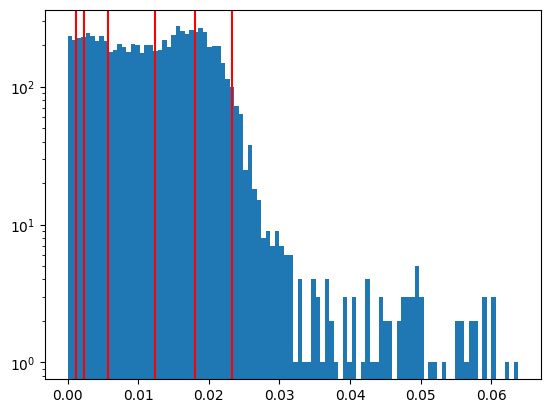

[0.00113333 0.00230127 0.00566522 0.01241712 0.01801981 0.02332546]


In [6]:
feat = 2306

# now only look in CD8+ T cells

cd8_indices = np.where(data.obs['cell_type'] == 'CD8+ T')[0]

activs_feat = activations[cd8_indices, feat].detach().cpu().numpy()
# kick out the zeros (this is where the feature is not active, and this screws up the quantiles)
activs_feat = activs_feat[activs_feat > 0]

quantile_steps = [0.05, 0.1, 0.25, 0.5, 0.75, 0.95]
quantiles = np.quantile(activs_feat, quantile_steps)

plt.hist(activs_feat, bins=100)
# make lines at each quantile
for q in quantiles:
    plt.axvline(q, color='red')
plt.yscale('log')
plt.show()

print(quantiles)

Thresholds: 0.0011333319358527662 (0.05 quantile) and 0.023325456492602824 (0.95 quantile)


/tmp/ipykernel_643674/1877484566.py:33: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(df_temp[df_temp['type'] != 'active'], x='PC 1', y='PC 2', hue='type', s=1, ax=axs[0], alpha=0.5, palette=['grey', 'black', 'red'])


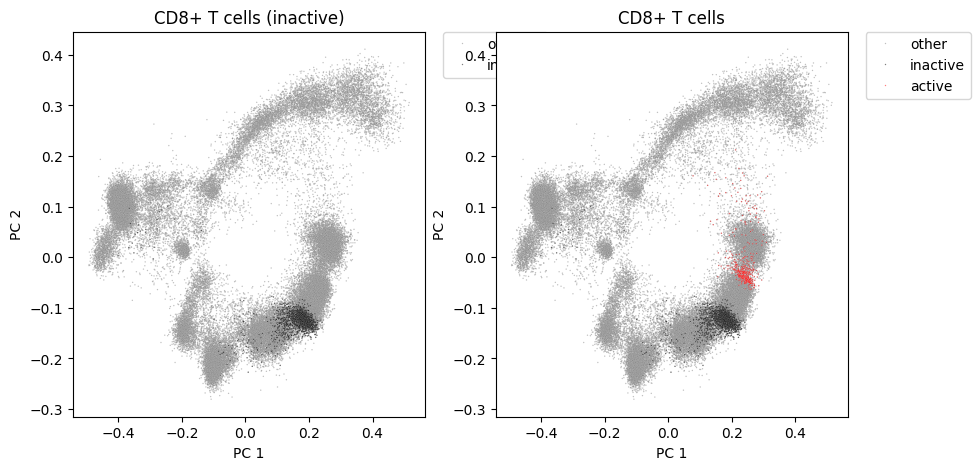

In [18]:
feat = 2306

i = 0
j = -1
thresholds = [quantiles[i], quantiles[j]]
print(f'Thresholds: {thresholds[0]} ({quantile_steps[i]} quantile) and {thresholds[1]} ({quantile_steps[j]} quantile)')

# get indices of CD8+T cells and indices of where the feature is active (> 0.01)
ct_indices = np.where(data.obs['cell_type'] == 'CD8+ T')[0]
feat_indices_pos = np.where(activations.detach().cpu()[:, feat] > thresholds[1])[0]
feat_indices_neg = np.where(activations.detach().cpu()[:, feat] < thresholds[0])[0]

ct_pos_indices = np.intersect1d(ct_indices, feat_indices_pos)
#ct_neg_indices = np.setdiff1d(ct_indices, ct_pos_indices)
ct_neg_indices = np.intersect1d(ct_indices, feat_indices_neg)

latents_pos = reps[ct_pos_indices, :].cpu().numpy()
latents_neg = reps[ct_neg_indices, :].cpu().numpy()
activs_pos = activations[ct_pos_indices, :]
activs_neg = activations[ct_neg_indices, :]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

df_temp = pd.DataFrame(reps_transformed, columns=['PC 1', 'PC 2'])
df_temp['type'] = 'other'
df_temp2 = pd.DataFrame(pca.transform(latents_neg), columns=['PC 1', 'PC 2'])
df_temp2['type'] = 'inactive'
df_temp = pd.concat([df_temp, df_temp2])
df_temp2 = pd.DataFrame(pca.transform(latents_pos), columns=['PC 1', 'PC 2'])
df_temp2['type'] = 'active'
df_temp = pd.concat([df_temp, df_temp2])

sns.scatterplot(df_temp[df_temp['type'] != 'active'], x='PC 1', y='PC 2', hue='type', s=1, ax=axs[0], alpha=0.5, palette=['grey', 'black', 'red'])
axs[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[0].set_title('CD8+ T cells (inactive)')

sns.scatterplot(df_temp, x='PC 1', y='PC 2', hue='type', s=1, ax=axs[1], alpha=0.5, palette=['grey', 'black', 'red'])
axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[1].set_title('CD8+ T cells')
plt.show()

In [ ]:

###
# DEG analysis
###

# get all necessary extras for predictions (model predctions are better than just raw data)
library_pos = data.obs['GEX_n_counts'].values[ct_pos_indices]
library_neg = data.obs['GEX_n_counts'].values[ct_neg_indices]
cov_latents_pos = model.correction_rep.z.detach()[ct_pos_indices, :]
cov_latents_neg = model.correction_rep.z.detach()[ct_neg_indices, :]

# make predictions
y_pos = model.decoder(torch.cat((torch.tensor(latents_pos).to(device), cov_latents_pos), dim=1))[0].detach().cpu().numpy()
y_neg = model.decoder(torch.cat((torch.tensor(latents_neg).to(device), cov_latents_neg), dim=1))[0].detach().cpu().numpy()
# rescale
y_pos = y_pos * library_pos.reshape(-1, 1)
y_neg = y_neg * library_neg.reshape(-1, 1)

from scipy import stats
from statsmodels.stats.multitest import multipletests

fold_changes = y_pos.mean(axis=0) / y_neg.mean(axis=0)

# Perform unpaired t-tests for each gene
p_values = []
for gene in range(y_pos.shape[1]):
    t_stat, p_val = stats.ttest_ind(y_pos[:,gene], y_neg[:,gene], equal_var=False)  # Unequal variance (Welch's t-test)
    p_values.append(p_val)

# Convert the p-values into a numpy array for further processing
p_values = np.array(p_values)

# Adjust p-values using Benjamini-Hochberg correction (FDR)
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

# Convert p-values and fold changes into a DataFrame
gene_p_values = pd.DataFrame({
    'gene': (data.var[data.var['modality'] == 'GEX']).index,  # Assuming you have gene names as your columns' index
    'p_value': p_values,
    'fold_change': fold_changes,
    'adj_p_value': adjusted_p_values
})

# Sort the results by p-value
gene_p_values = gene_p_values.sort_values(by='p_value')

# Print the top differentially expressed genes
print(gene_p_values.head())

# look at the genes above a certain threshold
fold_change_threshold = [0.5, 2.0]
p_value_threshold = 0.05
top_genes = gene_p_values[((gene_p_values['fold_change'] < fold_change_threshold[0]) | (gene_p_values['fold_change'] > fold_change_threshold[1])) & (gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

# plot fold change against adjusted p value
plt.figure(figsize=(10, 5))
sns.scatterplot(data=gene_p_values, x='fold_change', y='adj_p_value')
plt.xlabel('Fold Change')
plt.ylabel('Adjusted p-value')
plt.title('Differential Gene Expression')
top_genes_indices = np.where(gene_p_values['gene'].isin(top_genes))[0]
sns.scatterplot(data=gene_p_values.iloc[top_genes_indices], x='fold_change', y='adj_p_value', color='red')
plt.legend()
plt.show()

print(top_genes)

top_genes.to_csv(f'03_results/models/CD8_pos-neg_feature{feat}_significant_genes_foldchange2_pval05_v2.txt', sep='\t', index=False, header=False)

In [17]:
fold_change_threshold = [0.1, 10.0]
p_value_threshold = 1e-10
top_genes = gene_p_values[((gene_p_values['fold_change'] < fold_change_threshold[0]) | (gene_p_values['fold_change'] > fold_change_threshold[1])) & (gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/CD8_pos-neg_feature{feat}_significant_genes_foldchange10_pval1e-10_v2.txt', sep='\t', index=False, header=False)

2121           CD28
3633           IL7R
1092     AL136456.1
4909           CCR6
1950           DPP4
7018         ADAM12
195           RCAN3
1949        SLC4A10
13275         VSIG1
2406           CCR4
8001          NELL2
2122          CTLA4
7235        TSPAN18
5652          DUSP4
13169         FAAH2
9609         HAPLN3
6564          IL2RA
3455     AC139720.1
4083         ADAM19
2439         CX3CR1
12458    AL109930.1
7573         PRSS23
10059        ADGRG1
8838           GZMB
3139         FGFBP2
12457         TSHZ2
1975          MYO3B
6074         LINGO2
Name: gene, dtype: object


In [ ]:
# try with the GLM with negative binomial 

# get all necessary extras for predictions (model predctions are better than just raw data)
library_pos = data.obs['GEX_n_counts'].values[ct_pos_indices]
library_neg = data.obs['GEX_n_counts'].values[ct_neg_indices]
cov_latents_pos = model.correction_rep.z.detach()[ct_pos_indices, :]
cov_latents_neg = model.correction_rep.z.detach()[ct_neg_indices, :]

# make predictions
y_pos = model.decoder(torch.cat((torch.tensor(latents_pos).to(device), cov_latents_pos), dim=1))[0].detach().cpu().numpy()
y_neg = model.decoder(torch.cat((torch.tensor(latents_neg).to(device), cov_latents_neg), dim=1))[0].detach().cpu().numpy()
# rescale
y_pos = y_pos * library_pos.reshape(-1, 1)
y_neg = y_neg * library_neg.reshape(-1, 1)

p_values = []
fold_changes = []

# use the GLM model with negative binomial distribution (but data is not paired)

for gene in range(y_pos.shape[1]):
    gene_expression = np.concatenate([y_pos[:, gene], y_neg[:, gene]])
    X = np.column_stack([
        np.ones(len(gene_expression)),
        np.concatenate([np.zeros(len(y_pos)), np.ones(len(y_neg))])
    ])
    glm_model = sm.GLM(gene_expression, X, family=sm.families.NegativeBinomial(alpha=dispersion_factors[gene]))
    result = glm_model.fit()
    p_values.append(result.pvalues[1])
    fold_changes.append(np.exp(result.params[1]))

from statsmodels.stats.multitest import multipletests
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

# Convert p-values and fold changes into a DataFrame
gene_p_values = pd.DataFrame({
    'gene': (data.var[data.var['modality'] == 'GEX']).index,  # Assuming you have gene names as your columns' index
    'p_value': p_values,
    'fold_change': fold_changes,
    'adj_p_value': adjusted_p_values
})

# Sort the results by p-value
gene_p_values = gene_p_values.sort_values(by='p_value')

# Print the top differentially expressed genes
print(gene_p_values.head())

# look at the genes above a certain threshold
fold_change_threshold = [0.5, 2.0]
p_value_threshold = 0.05
top_genes = gene_p_values[((gene_p_values['fold_change'] < fold_change_threshold[0]) | (gene_p_values['fold_change'] > fold_change_threshold[1])) & (gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

# plot fold change against adjusted p value
plt.figure(figsize=(10, 5))
sns.scatterplot(data=gene_p_values, x='fold_change', y='adj_p_value')
plt.xlabel('Fold Change')
plt.ylabel('Adjusted p-value')
plt.title('Differential Gene Expression')
top_genes_indices = np.where(gene_p_values['gene'].isin(top_genes))[0]
sns.scatterplot(data=gene_p_values.iloc[top_genes_indices], x='fold_change', y='adj_p_value', color='red')
plt.legend()
plt.show()

print(top_genes)

top_genes.to_csv(f'03_results/models/CD8_pos-neg_feature{feat}_significant_genes_foldchange2_pval05_v2_glmNB.txt', sep='\t', index=False, header=False)

In [24]:
p_value_threshold = 1e-10
top_genes = gene_p_values[(gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/CD8_pos-neg_feature{feat}_significant_genes_pval1e-10_v2_glmNB.txt', sep='\t', index=False, header=False)

1708       GNLY
8837       GZMH
12027      NKG7
8838       GZMB
3139     FGFBP2
          ...  
4260      ATXN1
1975      MYO3B
3241     IGFBP7
3688       GZMA
2628      FOXP1
Name: gene, Length: 121, dtype: object


In [25]:
fold_change_threshold = [0.1, 10.0]
p_value_threshold = 1e-10
top_genes = gene_p_values[((gene_p_values['fold_change'] < fold_change_threshold[0]) | (gene_p_values['fold_change'] > fold_change_threshold[1])) & (gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/CD8_pos-neg_feature{feat}_significant_genes_foldchange10_pval1e-10_v2_glmNB.txt', sep='\t', index=False, header=False)

8838           GZMB
3139         FGFBP2
3633           IL7R
10059        ADGRG1
2439         CX3CR1
7573         PRSS23
1092     AL136456.1
6074         LINGO2
8001          NELL2
1949        SLC4A10
1975          MYO3B
Name: gene, dtype: object


In [26]:
fold_change_threshold = [0.5, 2.0]
p_value_threshold = 1e-10
top_genes = gene_p_values[((gene_p_values['fold_change'] < fold_change_threshold[0]) | (gene_p_values['fold_change'] > fold_change_threshold[1])) & (gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/CD8_pos-neg_feature{feat}_significant_genes_foldchange2_pval1e-10_v2_glmNB.txt', sep='\t', index=False, header=False)

1708       GNLY
8837       GZMH
12027      NKG7
8838       GZMB
3139     FGFBP2
          ...  
8716     GPR183
1278      PCNX2
5628      DOCK5
1975      MYO3B
3241     IGFBP7
Name: gene, Length: 109, dtype: object


In [27]:
fold_change_threshold = [0.2, 5.0]
p_value_threshold = 1e-10
top_genes = gene_p_values[((gene_p_values['fold_change'] < fold_change_threshold[0]) | (gene_p_values['fold_change'] > fold_change_threshold[1])) & (gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/CD8_pos-neg_feature{feat}_significant_genes_foldchange5_pval1e-10_v2_glmNB.txt', sep='\t', index=False, header=False)

1708           GNLY
8837           GZMH
8838           GZMB
3139         FGFBP2
3633           IL7R
3454         INPP4B
1070        C1orf21
3870          CAMK4
6717           ANK3
10586    AC243829.2
3065          SPON2
10059        ADGRG1
2439         CX3CR1
4389            LTB
7872          KLRF1
4076           SGCD
2917          PPM1L
969          FCGR3A
5552          MYOM2
7573         PRSS23
3476          NR3C2
1092     AL136456.1
3687           GZMK
8197       IFNG-AS1
8200      LINC02384
7652          NCAM1
6074         LINGO2
6293      LINC01505
8001          NELL2
12954         TTC38
5928          PCAT1
491            PATJ
6052           BNC2
3796        RASGRF2
6512          PTGDS
3380           LEF1
3854        SLCO4C1
1949        SLC4A10
1975          MYO3B
3241         IGFBP7
Name: gene, dtype: object


In [28]:
fold_change_threshold = [0.2, 5.0]
p_value_threshold = 1e-5
top_genes = gene_p_values[((gene_p_values['fold_change'] < fold_change_threshold[0]) | (gene_p_values['fold_change'] > fold_change_threshold[1])) & (gene_p_values['adj_p_value'] < p_value_threshold)]['gene']

print(top_genes)

top_genes.to_csv(f'03_results/models/CD8_pos-neg_feature{feat}_significant_genes_foldchange5_pval1e-5_v2_glmNB.txt', sep='\t', index=False, header=False)

1708           GNLY
8837           GZMH
8838           GZMB
3139         FGFBP2
3633           IL7R
3454         INPP4B
1070        C1orf21
3870          CAMK4
6717           ANK3
10586    AC243829.2
3065          SPON2
10059        ADGRG1
2439         CX3CR1
4389            LTB
7872          KLRF1
4076           SGCD
2917          PPM1L
969          FCGR3A
5552          MYOM2
7573         PRSS23
3476          NR3C2
1092     AL136456.1
3687           GZMK
8197       IFNG-AS1
8200      LINC02384
7652          NCAM1
6074         LINGO2
6293      LINC01505
8001          NELL2
12954         TTC38
5928          PCAT1
491            PATJ
6052           BNC2
3796        RASGRF2
6512          PTGDS
3380           LEF1
3854        SLCO4C1
1949        SLC4A10
1975          MYO3B
3241         IGFBP7
5068          EPDR1
5934           PVT1
3860          EFNA5
6555         AKR1C3
195           RCAN3
2121           CD28
6336         TNFSF8
7899         DUSP16
12457         TSHZ2
2690          TRAT1
